#Exercise 4: Auto-regressive models
Name: Azmi Haider
ID: 308139385

In this tutorial, we implement an autoregressive likelihood model for the task of image modeling. Autoregressive models are naturally strong generative models that constitute one of the current state-of-the-art architectures on likelihood-based image modeling, and are also the basis for large language generation models such as GPT3. Similar to the language generation you have seen in assignment 2, autoregressive models work on images by modeling the likelihood of a pixel given all previous ones. For instance, in the picture below, we model the pixel $x_i$ as a conditional probability distribution based on all previous (here blue) pixels (figure credit - [Aaron van den Oord et al.](https://arxiv.org/abs/1601.06759)):

<center width="100%" style="padding: 10px"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial12/autoregressive_image_modeling.svg?raw=1" width="200px"></center>

Generally, autoregressive model over high-dimensional data $\mathbf{x}$ factor the joint distribution as the following product of conditionals:

$$p(\mathbf{x})=p(x_1, ..., x_n)=\prod_{i=1}^{n} p(x_i|x_1,...,x_{i-1})$$

Learning these conditionals is often much simpler than learning the joint distribution $p(\mathbf{x})$ all together. However, disadvantages of autoregressive models include slow sampling, especially for large images, as we need height-times-width forward passes through the model. In addition, for some applications, we require a latent space as modeled in VAEs and Normalizing Flows. For instance, in autoregressive models, we cannot interpolate between two images because of the lack of a latent representation.
We will explore and discuss these benefits and drawbacks alongside with our implementation.

Our implementation will focus on the [PixelCNN](https://arxiv.org/pdf/1606.05328.pdf) [2] model which has been discussed in detail in the lecture. Most current SOTA models use PixelCNN as their fundamental architecture, and various additions have been proposed to improve the performance (e.g. [PixelCNN++](https://arxiv.org/pdf/1701.05517.pdf) and [PixelSNAIL](http://proceedings.mlr.press/v80/chen18h/chen18h.pdf)). Hence, implementing PixelCNN is a good starting point for our short tutorial.

First of all, we need to import our standard libraries. Similarly as in the last couple of tutorials, we will use [PyTorch Lightning](https://pytorch-lightning.readthedocs.io/en/latest/) here as well.

In [1]:
## Standard libraries
import os
import math
import numpy as np

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import seaborn as sns

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial12"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

<ipython-input-1-08983a184527>:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
INFO:lightning_fabric.utilities.seed:Seed set to 42


Using device cpu


<Figure size 640x480 with 0 Axes>

MNIST dataset download and prepare data

In [2]:
# Convert images from 0-1 to 0-255 (integers). We use the long datatype as we will use the images as labels as well
def discretize(sample):
    return (sample * 255).to(torch.long)

# Transformations applied on each image => only make them a tensor
transform = transforms.Compose([transforms.ToTensor(),
                                discretize])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
pl.seed_everything(42)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = MNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16223369.93it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 490342.55it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4382405.34it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1923907.17it/s]
INFO:lightning_fabric.utilities.seed:Seed set to 42


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


A good practice is to always visualize some data examples to get an intuition of the data:

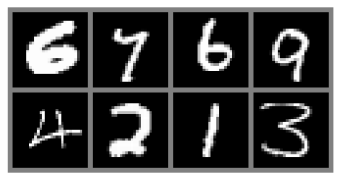

In [3]:
def show_imgs(imgs):
    num_imgs = imgs.shape[0] if isinstance(imgs, torch.Tensor) else len(imgs)
    nrow = min(num_imgs, 4)
    ncol = int(math.ceil(num_imgs/nrow))
    imgs = torchvision.utils.make_grid(imgs, nrow=nrow, pad_value=128)
    imgs = imgs.clamp(min=0, max=255)
    np_imgs = imgs.cpu().numpy()
    plt.figure(figsize=(1.5*nrow, 1.5*ncol))
    plt.imshow(np.transpose(np_imgs, (1,2,0)), interpolation='nearest')
    plt.axis('off')
    plt.show()
    plt.close()

show_imgs([train_set[i][0] for i in range(8)])

## Masked autoregressive convolutions

The core module of PixelCNN is its masked convolutions. In contrast to language models, we don't apply an LSTM on each pixel one-by-one. This would be inefficient because images are grids instead of sequences. Thus, it is better to rely on convolutions that have shown great success in deep CNN classification models.

Nevertheless, we cannot just apply standard convolutions without any changes.
Remember that during training of autoregressive models, we want to use teacher forcing which both helps the model training, and significantly reduces the time needed for training. For image modeling, teacher forcing is implemented by using a training image as input to the model, and we want to obtain as output the prediction for each pixel based on *only* its predecessors.
Thus, we need to ensure that the prediction for a specific pixel can only be influenced by its predecessors and not by its own value or any "future" pixels.
For this, we apply convolutions with a mask.

Which mask we use depends on the ordering of pixels we decide on, i.e. which is the first pixel we predict, which is the second one, etc.
The most commonly used ordering is to denote the upper left pixel as the start pixel, and sort the pixels row by row, as shown in the visualization at the top of the tutorial.
Thus, the second pixel is on the right of the first one (first row, second column), and once we reach the end of the row, we start in the second row, first column.
If we now want to apply this to our convolutions, we need to ensure that the prediction of pixel 1 is not influenced by its own "true" input, and all pixels on its right and in any lower row. In convolutions, this means that we want to set those entries of the weight matrix to zero that take pixels on the right and below into account. As an example for a 5x5 kernel, see a mask below (figure credit - [Aaron van den Oord](https://arxiv.org/pdf/1606.05328.pdf)):

<center width="100%" style="padding: 10px"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial12/masked_convolution.svg?raw=1" width="150px"></center>

Before looking into the application of masked convolutions in PixelCNN in detail, let's first implement a module that allows us to apply an arbitrary mask to a convolution:

In [4]:
class MaskedConvolution(nn.Module):

    def __init__(self, c_in, c_out, mask, **kwargs):
        """
        Implements a convolution with mask applied on its weights.
        Inputs:
            c_in - Number of input channels
            c_out - Number of output channels
            mask - Tensor of shape [kernel_size_H, kernel_size_W] with 0s where
                   the convolution should be masked, and 1s otherwise.
            kwargs - Additional arguments for the convolution
        """
        super().__init__()
        # For simplicity: calculate padding automatically
        kernel_size = (mask.shape[0], mask.shape[1])
        dilation = 1 if "dilation" not in kwargs else kwargs["dilation"]
        padding = tuple([dilation*(kernel_size[i]-1)//2 for i in range(2)])
        # Actual convolution
        self.conv = nn.Conv2d(c_in, c_out, kernel_size, padding=padding, **kwargs)

        # Mask as buffer => it is no parameter but still a tensor of the module
        # (must be moved with the devices)
        self.register_buffer('mask', mask[None,None])

    def forward(self, x):
        self.conv.weight.data *= self.mask # Ensures zero's at masked positions
        return self.conv(x)

### Vertical and horizontal convolution stacks

To build our own autoregressive image model, we could simply stack a few masked convolutions on top of each other.
This was actually the case for the original PixelCNN model, discussed in the paper [Pixel Recurrent Neural Networks](https://arxiv.org/pdf/1601.06759.pdf), but this leads to a considerable issue.
When sequentially applying a couple of masked convolutions, the receptive field of a pixel show to have a "blind spot" on the right upper side, as shown in the figure below (figure credit - [Aaron van den Oord et al.](https://arxiv.org/pdf/1606.05328.pdf)):

<center width="100%" style="padding: 10px"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial12/pixelcnn_blind_spot.svg?raw=1" width="275px"></center>

Although a pixel should be able to take into account all other pixels above and left of it, a stack of masked convolutions does not allow us to look to the upper pixels on the right. This is because the features of the pixels above, which we use for convolution, do not contain any information of the pixels on the right of the same row. If they would, we would be "cheating" and actually looking into the future. To overcome this issue, van den Oord et. al [2] proposed to split the convolutions into a vertical and a horizontal stack. The vertical stack looks at all pixels above the current one, while the horizontal takes into account all on the left. While keeping both of them separate, we can actually look at the pixels on the right with the vertical stack without breaking any of our assumptions. The two convolutions are also shown in the figure above.

Let us implement them here as follows:

In [5]:
class VerticalStackConvolution(MaskedConvolution):

    def __init__(self, c_in, c_out, kernel_size=3, mask_center=False, **kwargs):
        # Mask out all pixels below. For efficiency, we could also reduce the kernel
        # size in height, but for simplicity, we stick with masking here.
        mask = torch.ones(kernel_size, kernel_size)
        mask[kernel_size//2+1:,:] = 0

        # For the very first convolution, we will also mask the center row
        if mask_center:
            mask[kernel_size//2,:] = 0

        super().__init__(c_in, c_out, mask, **kwargs)

class HorizontalStackConvolution(MaskedConvolution):

    def __init__(self, c_in, c_out, kernel_size=3, mask_center=False, **kwargs):
        # Mask out all pixels on the left. Note that our kernel has a size of 1
        # in height because we only look at the pixel in the same row.
        mask = torch.ones(1,kernel_size)
        mask[0,kernel_size//2+1:] = 0

        # For the very first convolution, we will also mask the center pixel
        if mask_center:
            mask[0,kernel_size//2] = 0

        super().__init__(c_in, c_out, mask, **kwargs)

Note that we have an input argument called `mask_center`. Remember that the input to the model is the actual input image. Hence, the very first convolution we apply cannot use the center pixel as input, but must be masked. All consecutive convolutions, however, should use the center pixel as we otherwise lose the features of the previous layer. Hence, the input argument `mask_center` is True for the very first convolutions, and False for all others.

# My implementation of Masked Convolution (No gates or dialation)

In [ ]:
class MaskedConv(nn.Module):

    def __init__(self, c_in, **kwargs):
        """
        Gated Convolution block implemented the computation graph shown above.
        """
        super().__init__()
        self.conv_vert = VerticalStackConvolution(c_in, c_out=c_in, **kwargs)
        self.conv_horiz = HorizontalStackConvolution(c_in, c_out=c_in, **kwargs)
        self.conv_vert_to_horiz = nn.Conv2d(c_in, c_in, kernel_size=1, padding=0)
        self.conv_horiz_1x1 = nn.Conv2d(c_in, c_in, kernel_size=1, padding=0)

    def forward(self, v_stack, h_stack):
        # Vertical stack (left)
        v_stack = self.conv_vert(v_stack)

        # Horizontal stack (right)
        h_stack = self.conv_horiz(h_stack)
        h_stack = h_stack + self.conv_vert_to_horiz(v_stack)

        return v_stack, h_stack

# Building the model
### Using Vertical/Horizontal stacks (no gated convolutions or dialation)

In [ ]:
class PixelCNN(pl.LightningModule):

    def __init__(self, c_in, c_hidden, causal=True):
        super().__init__()
        self.save_hyperparameters()

        # Initial convolutions skipping the center pixel
        self.conv_vstack = VerticalStackConvolution(c_in, c_hidden,kernel_size=7, mask_center=causal)
        self.conv_hstack = HorizontalStackConvolution(c_in, c_hidden,kernel_size=7, mask_center=causal)
        # Convolution block, vertical/Horizontal stacks
        self.conv_layers = nn.ModuleList([
            MaskedConv(c_hidden,kernel_size=3),
            MaskedConv(c_hidden,kernel_size=3),
            MaskedConv(c_hidden,kernel_size=3),
            MaskedConv(c_hidden,kernel_size=3),
            MaskedConv(c_hidden,kernel_size=3),
            MaskedConv(c_hidden,kernel_size=3),
            MaskedConv(c_hidden,kernel_size=3)
        ])
        # Output classification convolution (1x1)
        self.conv_out = nn.Conv2d(c_hidden, c_in * 256, kernel_size=1, padding=0)

        # loggin
        self.train_epoch_loss = []
        self.train_loss = []

        self.val_epoch_loss = []
        self.val_loss = []

    def forward(self, x):
        """
        Forward image through model and return logits for each pixel.
        Inputs:
            x - Image tensor with integer values between 0 and 255.
        """
        # Scale input from 0 to 255 back to -1 to 1
        x = (x.float() / 255.0) * 2 - 1

        # Initial convolutions
        v_stack = self.conv_vstack(x)
        h_stack = self.conv_hstack(x)
        # Gated Convolutions
        for layer in self.conv_layers:
            v_stack, h_stack = layer(v_stack, h_stack)
        # 1x1 classification convolution
        # Apply ELU before 1x1 convolution for non-linearity on residual connection
        out = self.conv_out(F.elu(h_stack))

        # Output dimensions: [Batch, Classes, Channels, Height, Width]
        out = out.reshape(out.shape[0], 256, out.shape[1]//256, out.shape[2], out.shape[3])
        return out

    def calc_likelihood(self, x):
        # Forward pass with bpd likelihood calculation
        pred = self.forward(x)
        nll = F.cross_entropy(pred, x, reduction='none')
        bpd = nll.mean(dim=[1,2,3]) * np.log2(np.exp(1))
        return bpd.mean()

    @torch.no_grad()
    def sample(self, img_shape, img=None):
        """
        Sampling function for the autoregressive model.
        Inputs:
            img_shape - Shape of the image to generate (B,C,H,W)
            img (optional) - If given, this tensor will be used as
                             a starting image. The pixels to fill
                             should be -1 in the input tensor.
        """
        # Create empty image
        if img is None:
            img = torch.zeros(img_shape, dtype=torch.long).to(device) - 1
        # Generation loop
        for h in tqdm(range(img_shape[2]), leave=False):
            for w in range(img_shape[3]):
                for c in range(img_shape[1]):
                    # Skip if not to be filled (-1)
                    if (img[:,c,h,w] != -1).all().item():
                        continue
                    # For efficiency, we only have to input the upper part of the image
                    # as all other parts will be skipped by the masked convolutions anyways
                    pred = self.forward(img[:,:,:h+1,:])
                    probs = F.softmax(pred[:,:,c,h,w], dim=-1)
                    img[:,c,h,w] = torch.multinomial(probs, num_samples=1).squeeze(dim=-1)
        return img

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.99)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        loss = self.calc_likelihood(batch[0])
        self.log('train_bpd', loss, on_epoch=True, prog_bar=True, logger=True)
        self.train_epoch_loss.append(loss.detach().item())
        return loss

    def on_train_epoch_end(self):
        self.train_loss.append(np.mean(self.train_epoch_loss))
        self.train_epoch_loss = []

    def validation_step(self, batch, batch_idx):
        loss = self.calc_likelihood(batch[0])
        self.log('val_bpd', loss, on_epoch=True, prog_bar=True, logger=True)
        self.val_epoch_loss.append(loss.detach().item())

    def on_validation_epoch_end(self):
        self.val_loss.append(np.mean(self.val_epoch_loss))
        self.val_epoch_loss = []

    def test_step(self, batch, batch_idx):
        loss = self.calc_likelihood(batch[0])
        self.log('test_bpd', loss, on_epoch=True, prog_bar=True, logger=True)


### Training loop

To train the model, we again can rely on PyTorch Lightning and write a function below for loading the pretrained model if it exists. To reduce the computational cost, we have saved the validation and test score in the checkpoint already:

In [6]:
def train_model(**kwargs):
    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "PixelCNN"),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=20,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_bpd"),
                                    LearningRateMonitor("epoch")])
    result = None
    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "PixelCNN.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = PixelCNN.load_from_checkpoint(pretrained_filename)
        ckpt = torch.load(pretrained_filename, map_location=device)
        result = ckpt.get("result", None)
    else:
        model = PixelCNN(**kwargs)
        trainer.fit(model, train_loader, val_loader)
        test_result = trainer.test(model, test_loader, verbose=False)
        test_res = test_result[0]["test_bpd"]
        print(f"Test bpd : {test_res}")
    model = model.to(device)
    return model



---
---
---
---
##Here starts the solution of the sections in the pdf
---
---
---
---

# Section1 : Train model - masked convolution (no gated/dilation)

In [ ]:
model = train_model(c_in=1, c_hidden=64)


### Runnning in Colab is taking too much time (denied access to GPUs). I'm going to run on my own laptop (NVIDIA GeForce RTX 3050) - same code with 50 epochs (takes ~1hr). Attached results are below, the checkpoint is also saved if needed will be sent to checker.

## Plot results

In [ ]:
plt.figure()
plt.plot(model.train_loss, label='Train NLL')
plt.plot(model.val_loss, label='Val NLL')
plt.xlabel('Epoch')
plt.ylabel('NLL')
plt.legend()
plt.grid(True)
plt.title('Negative Log Likelihoods over Epochs')
plt.show()

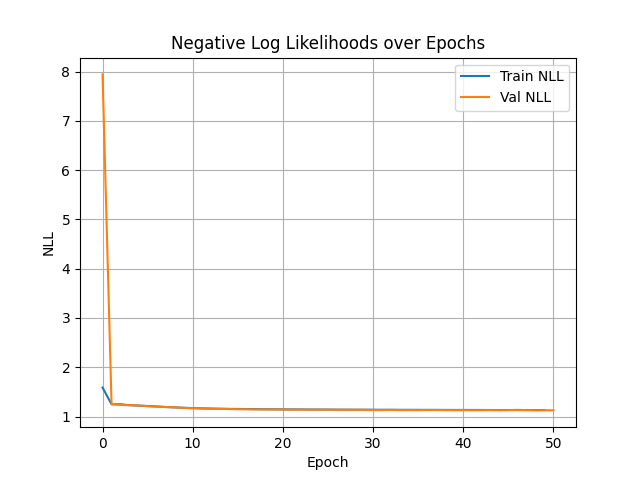

## Sampling

One way of qualitatively analysing generative models is by looking at the actual samples.
Let's therefore use our sampling function to generate a few digits:

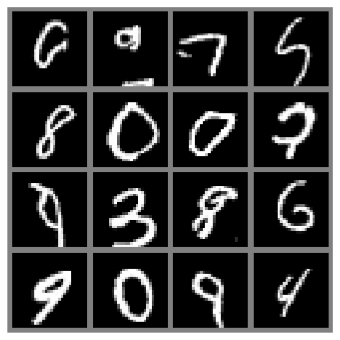

In [ ]:
pl.seed_everything(1)
samples = model.sample(img_shape=(16,1,28,28))
show_imgs(samples.cpu())

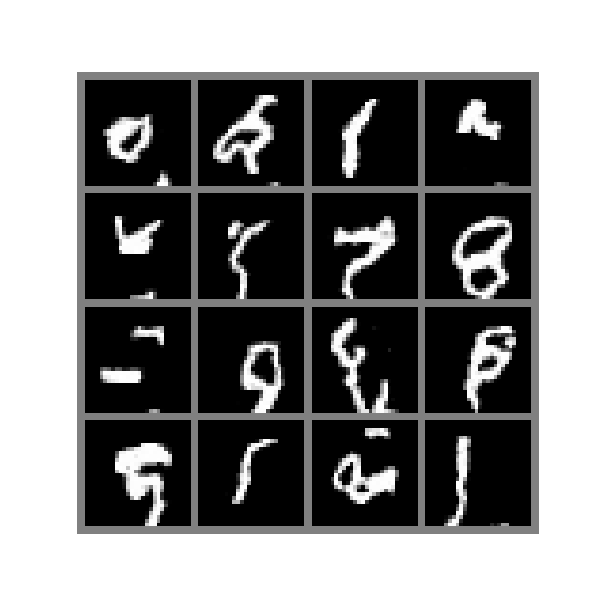

# section2 - Non causal model

I implemented a flag that turns off the causality in the first layer (meaning, the first vertical and horizontal masking layers takes the pixel into account)

In [ ]:
NC_model = train_model(c_in=1, c_hidden=64, causal= False)

## plot results of Non causal model

In [ ]:
plt.figure()
plt.plot(NC_model.train_loss, label='Train NLL')
plt.plot(NC_model.val_loss, label='Val NLL')
plt.xlabel('Epoch')
plt.ylabel('NLL')
plt.legend()
plt.grid(True)
plt.title('Negative Log Likelihoods over Epochs')
plt.show()

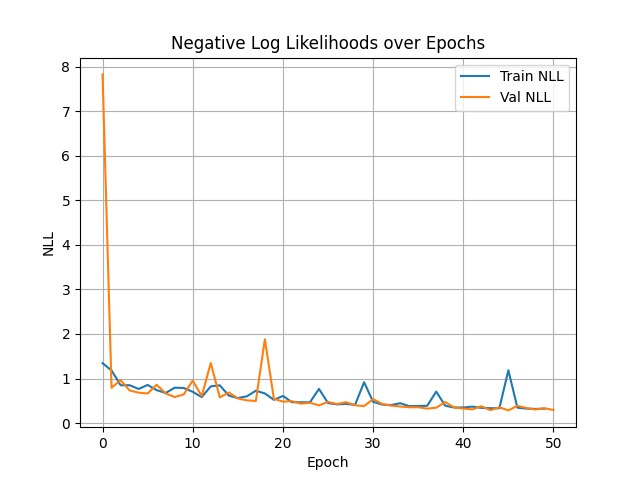

**Explanation:**  
    
**The loss is much smaller when using a non causal model. This is an expected behaviour as the model learns to look at the processed pixel value during training. Running for a long time will produce a model which simply passes the value of the pixel at each layer.**

## Sampling from Non causal model

In [ ]:
pl.seed_everything(1)
samples = NC_model.sample(img_shape=(16,1,28,28))
show_imgs(samples.cpu())

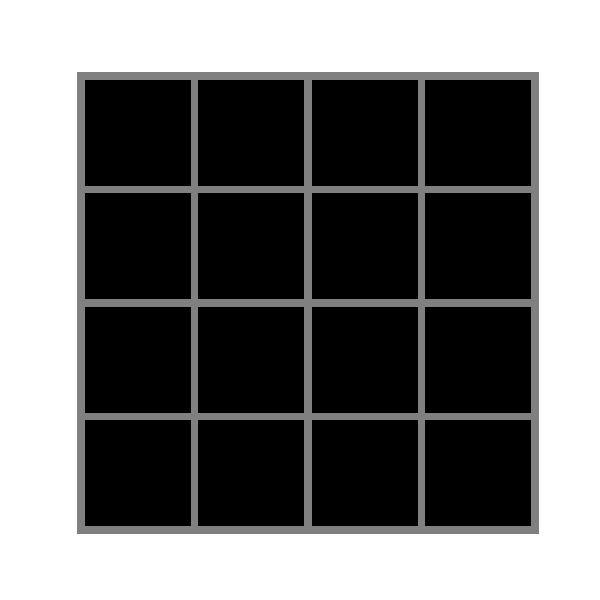

**Explanation:**  
  
**During sampling, the model (which learned to predict the proccessed pixel value from the pixel itself) doesn't have the information anymore. It passes the first pixel (which is black) to itself, and continues to do so for the whole image.**

# Section3: Distributions

I'm uploading the pretrained model for this section

## for that I need to add the Gated Convolution code and model architecture first:

In [7]:
class GatedMaskedConv(nn.Module):

    def __init__(self, c_in, **kwargs):
        """
        Gated Convolution block implemented the computation graph shown above.
        """
        super().__init__()
        self.conv_vert = VerticalStackConvolution(c_in, c_out=2*c_in, **kwargs)
        self.conv_horiz = HorizontalStackConvolution(c_in, c_out=2*c_in, **kwargs)
        self.conv_vert_to_horiz = nn.Conv2d(2*c_in, 2*c_in, kernel_size=1, padding=0)
        self.conv_horiz_1x1 = nn.Conv2d(c_in, c_in, kernel_size=1, padding=0)

    def forward(self, v_stack, h_stack):
        # Vertical stack (left)
        v_stack_feat = self.conv_vert(v_stack)
        v_val, v_gate = v_stack_feat.chunk(2, dim=1)
        v_stack_out = torch.tanh(v_val) * torch.sigmoid(v_gate)

        # Horizontal stack (right)
        h_stack_feat = self.conv_horiz(h_stack)
        h_stack_feat = h_stack_feat + self.conv_vert_to_horiz(v_stack_feat)
        h_val, h_gate = h_stack_feat.chunk(2, dim=1)
        h_stack_feat = torch.tanh(h_val) * torch.sigmoid(h_gate)
        h_stack_out = self.conv_horiz_1x1(h_stack_feat)
        h_stack_out = h_stack_out + h_stack

        return v_stack_out, h_stack_out


class PixelCNN(pl.LightningModule):

    def __init__(self, c_in, c_hidden):
        super().__init__()
        self.save_hyperparameters()

        # Initial convolutions skipping the center pixel
        self.conv_vstack = VerticalStackConvolution(c_in, c_hidden, mask_center=True)
        self.conv_hstack = HorizontalStackConvolution(c_in, c_hidden, mask_center=True)
        # Convolution block of PixelCNN. We use dilation instead of downscaling
        self.conv_layers = nn.ModuleList([
            GatedMaskedConv(c_hidden),
            GatedMaskedConv(c_hidden, dilation=2),
            GatedMaskedConv(c_hidden),
            GatedMaskedConv(c_hidden, dilation=4),
            GatedMaskedConv(c_hidden),
            GatedMaskedConv(c_hidden, dilation=2),
            GatedMaskedConv(c_hidden)
        ])
        # Output classification convolution (1x1)
        self.conv_out = nn.Conv2d(c_hidden, c_in * 256, kernel_size=1, padding=0)

        self.example_input_array = train_set[0][0][None]

    def forward(self, x):
        """
        Forward image through model and return logits for each pixel.
        Inputs:
            x - Image tensor with integer values between 0 and 255.
        """
        # Scale input from 0 to 255 back to -1 to 1
        x = (x.float() / 255.0) * 2 - 1

        # Initial convolutions
        v_stack = self.conv_vstack(x)
        h_stack = self.conv_hstack(x)
        # Gated Convolutions
        for layer in self.conv_layers:
            v_stack, h_stack = layer(v_stack, h_stack)
        # 1x1 classification convolution
        # Apply ELU before 1x1 convolution for non-linearity on residual connection
        out = self.conv_out(F.elu(h_stack))

        # Output dimensions: [Batch, Classes, Channels, Height, Width]
        out = out.reshape(out.shape[0], 256, out.shape[1]//256, out.shape[2], out.shape[3])
        return out

    def calc_likelihood(self, x):
        # Forward pass with bpd likelihood calculation
        pred = self.forward(x)
        nll = F.cross_entropy(pred, x, reduction='none')
        bpd = nll.mean(dim=[1,2,3]) * np.log2(np.exp(1))
        return bpd.mean()

    @torch.no_grad()
    def sample(self, img_shape, img=None):
        """
        Sampling function for the autoregressive model.
        Inputs:
            img_shape - Shape of the image to generate (B,C,H,W)
            img (optional) - If given, this tensor will be used as
                             a starting image. The pixels to fill
                             should be -1 in the input tensor.
        """
        # Create empty image
        if img is None:
            img = torch.zeros(img_shape, dtype=torch.long).to(device) - 1
        # Generation loop
        for h in tqdm(range(img_shape[2]), leave=False):
            for w in range(img_shape[3]):
                for c in range(img_shape[1]):
                    # Skip if not to be filled (-1)
                    if (img[:,c,h,w] != -1).all().item():
                        continue
                    # For efficiency, we only have to input the upper part of the image
                    # as all other parts will be skipped by the masked convolutions anyways
                    pred = self.forward(img[:,:,:h+1,:])
                    probs = F.softmax(pred[:,:,c,h,w], dim=-1)
                    img[:,c,h,w] = torch.multinomial(probs, num_samples=1).squeeze(dim=-1)
        return img

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.99)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        loss = self.calc_likelihood(batch[0])
        self.log('train_bpd', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.calc_likelihood(batch[0])
        self.log('val_bpd', loss)

    def test_step(self, batch, batch_idx):
        loss = self.calc_likelihood(batch[0])
        self.log('test_bpd', loss)


## Load pretrained model :

In [8]:
# Path to the folder where the pretrained models are saved
import urllib.request
from urllib.error import HTTPError
import os
CHECKPOINT_PATH = "../saved_models/tutorial12"

# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial12/"
# Files to download
pretrained_files = ["PixelCNN.ckpt"]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

model = train_model(c_in=1, c_hidden=64)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v0.9.0 to v2.3.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../saved_models/tutorial12/PixelCNN.ckpt`


Found pretrained model, loading...


### a) The marginal probability of the first pixel



To get an approximation of the marginal probability of a pixel, we can use the trained model to generate samples and then estimate the probability of observing the desired pixel value across those samples.
We don't need samples of size 28x28 if we're only looking at pixel (i,j). We can save time by sampling smaller images that reach the desired pixel.

INFO:lightning_fabric.utilities.seed:Seed set to 1


(256,)


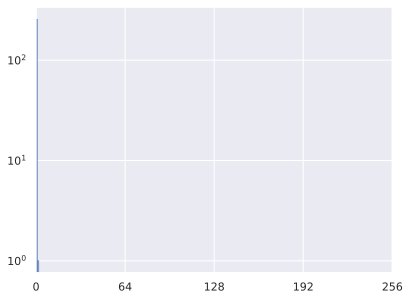

In [ ]:
pl.seed_everything(1)

img_shape = (1, 1, 1, 1)
img = torch.zeros(img_shape)
img = img.to(device)
with torch.no_grad():
    out = model(img)
    out = F.softmax(out, dim=1)
    out = out.cpu().numpy()
out = out.squeeze()
print(out.shape)

sns.set()
plot_args = {"color": to_rgb("C0")+(0.5,), "edgecolor": "C0", "linewidth": 0.5, "width": 1.0}
plt.hist(out, bins=256, density=True, **plot_args)
plt.yscale("log")
plt.xticks([0,64,128,192,256])
plt.show()
plt.close()

### b) The marginal probability of the middle pixel (14,14)


As explained before, we create samples of shape (15,28) so that the desired pixel (14,14) is in the last row. We don't need more pixels.

INFO:lightning_fabric.utilities.seed:Seed set to 1


  0%|          | 0/15 [00:00<?, ?it/s]

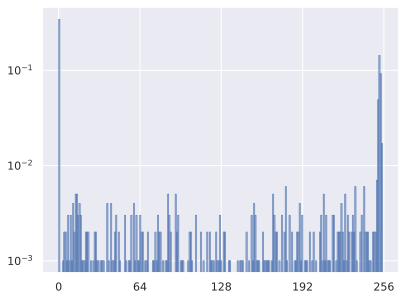

In [ ]:
pl.seed_everything(1)

img_shape = (1000, 1, 15, 28)
samples = model.sample(img_shape)
#show_imgs(samples.cpu())
value_across_all_samples = samples.squeeze()[:, 14, 14]

sns.set()
plot_args = {"color": to_rgb("C0")+(0.5,), "edgecolor": "C0", "linewidth": 0.5, "width": 1.0}
plt.hist(value_across_all_samples, bins=256, density=True, **plot_args)
plt.yscale("log")
plt.xticks([0,64,128,192,256])
plt.show()
plt.close()


### c) the conditional probability of the middle pixel, given the values of all pixels above and to the left of it.

Given an image from the dataset, we predict the probability vector of the pixel (14,14) conditioned on the information from the pixels up until (14,14) in the image.
We do that for multiple images from the dataset and average the probability.

(2, 256, 15, 28)


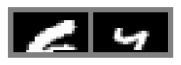

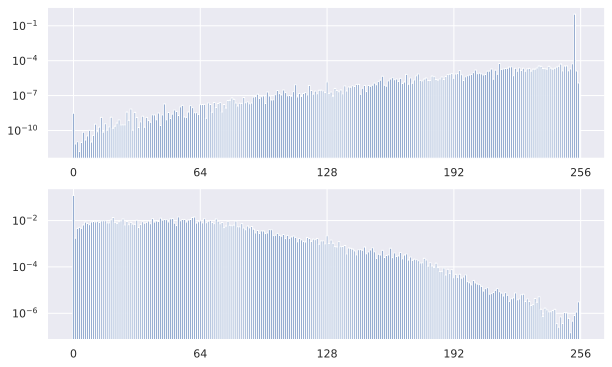

In [ ]:
# 2 images to condition on
N = 2
det_loader = data.DataLoader(train_set, batch_size=N, shuffle=False, drop_last=False)
imgs,_ = next(iter(det_loader))
imgs = imgs[:, :, :15,:] # delete all pixels below the middle
imgs[:, :, 14,15:] = -1 # delete all pixels to the right the middle
imgs = imgs.to(device)
with torch.no_grad():
    out = model(imgs)
    out = F.softmax(out, dim=1)
    out = out.cpu().numpy()
out = out.squeeze()
print(out.shape)
# show the images
show_imgs(imgs.cpu())
# Plot the conditioanal distribution
fig, ax = plt.subplots(N, 1, figsize=(10,6))
for i in range(2):
    ax_sub = ax[i]
    ax_sub.bar(np.arange(256), out[i,:, 14, 14])
    ax_sub.set_yscale("log")
    ax_sub.set_xticks([0,64,128,192,256])
plt.show()
plt.close()


### d) The conditional probability of the middle pixel, given the values of all pixels below and to the right of it.

This is very hard to calculate.
One way to do is to Sample N images. Out of all sampled images, only look at those with the bottom half matching the given values of pixels below and to the right of the middle pixel.
For those images, extract the value at the middle pixel. Collect these values and build a histogram from it, that would be an approximation to the conditional probability of the middle pixel.
Since our image is large (too many possibilities), we will need a very large number of samples until we reach many samples with desired values of bottom half.

### e) The conditional probability of the middle pixel, given the values of all other pixels in the image.


The possible values for the middle pixel are 0 to 255.    
We create 256 images, each with a different value.  
We then calculate the likelihood of each image using trained the model.  
We normalize the likelihood vector, this is the conditional probability for the middle pixel given all the values.
  

In [19]:
def conditional_likelihood_ij(model, imgs, i ,j):
  likelihood = torch.zeros((imgs.shape[0], 256))
  with torch.no_grad():
    for v in range(256):
      imgs_copy = imgs.clone()
      imgs_copy[:, :, i, j] = v
      pred = model.forward(imgs_copy)
      nll = F.cross_entropy(pred, imgs, reduction='none')
      nll = nll.mean(dim=[1,2,3]) * np.log2(np.exp(1))
      # nll represents the loss
      # high loss means small likelihood
      likelihood[:, v] = 1/ nll
  #print(nlls)
  return likelihood

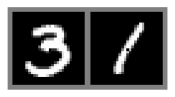

tensor(1.0000)
tensor(1.0000)


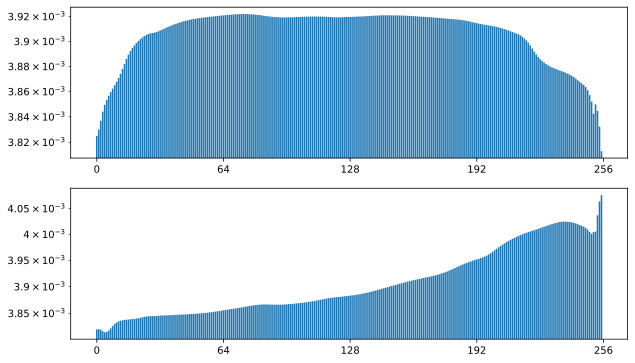

In [23]:
N = 2
det_loader = data.DataLoader(train_set, batch_size=N, shuffle=True, drop_last=False)

imgs,_ = next(iter(det_loader)) # shape = [N, 1, 28, 28]
imgs[:, :, 14, 14] = 0
likelihoods = conditional_likelihood_ij(model, imgs, 14, 14)

show_imgs(imgs.cpu())

# Plot the conditioanal distribution
fig, ax = plt.subplots(N, 1, figsize=(10,6))
for i in range(2):
    ax_sub = ax[i]
    lklh = likelihoods[i]
    lklh = lklh/sum(lklh)
    print(sum(lklh))
    ax_sub.bar(np.arange(256), lklh)
    ax_sub.set_yscale("log")
    ax_sub.set_xticks([0,64,128,192,256])
plt.show()
plt.close()


### f) Samples of the bottom half of an image, given the top half of an image.

Original image and input image to sampling:


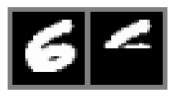

  0%|          | 0/28 [00:00<?, ?it/s]

Autocompletion samples:


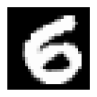

In [ ]:
img = train_set[0][0]
# Remove lower half of the image
img_init = img.clone()
img_init[:,14:,:] = -1
print("Original image and input image to sampling:")
show_imgs([img,img_init])
# Generate 12 example completions
img_init = img_init.unsqueeze(dim=0)

img_generated = model.sample(img_init.shape, img_init)
print("Autocompletion samples:")
show_imgs(img_generated)

The model utilizes the top half of the image to infer the rest of the image.

### g) Samples of the top half of an image, given the bottom half of an image.

We want to estimate and sample from the distribution $ P(top \space half = X_{0,0} ... X_{14,28} | bottom \space half = X_{15,0} ... X_{27,27}) $

We can use Gibbs sampling to estimate the distribution:  
1) initialize the top half with random values [0,255]  
2) for each pixel in the top half do:
$$ X_{i,j} \sim P(X_{i,j} | X_{-i,-j})$$
The probability $P(X_{i,j} | X_{-i,-j})$ can be calculated using the trained model as in (e) with the function **conditional_likelihood_ij(i,j)**.

After T mixing time, we will converge to the true distribution, which we can sample from.
